In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def generate_time_series(m, n_seq):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4,m,1)
    time = np.linspace(0, 1, n_seq)
    series = 0.5 *np.cos((time-offsets1) * (freq1 * 10 + 10))
    series += 0.3 *np.sin((time-offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(m, n_seq)-0.5)
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(1)
n_seq = 30
n_pred = 10

series = generate_time_series(5000, n_seq+n_pred)
series.shape

(5000, 40, 1)

In [4]:
x_train = series[:3000, :n_seq]
x_valid = series[3000:4000, :n_seq]
x_test = series[4000:,:n_seq]

In [5]:
y = np.empty((5000, n_seq, n_pred))

for step_ahead in range(1, n_pred+1):
    y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_seq,0]

y_train = y[:3000]
y_valid = y[3000:4000]
y_test = y[4000:]

In [6]:
x_train.shape, y_train.shape

((3000, 30, 1), (3000, 30, 10))

In [7]:
def plot_seq(x, y, y_pred=None):
    plt.plot(x, '.-')
    n_seq = x.shape[0]
    ahead = y.shape[0]
    plt.plot(np.arange(n_seq, n_seq+ahead), y, 'go-', label='$y$')
    if y_pred is not None:
        plt.plot(np.arange(n_seq, n_seq+ahead), y_pred, 'rx-',
                label='$\hat y$', markersize=10)
    plt.hlines(0, 0, n_seq + ahead, linewidth = 1)
    plt.axis([0, n_seq +ahead, -1, 1])
    plt.grid(True)
    plt.legend(fontsize=14)

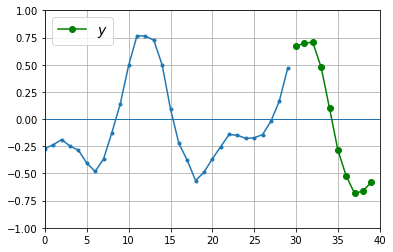

In [8]:
plot_seq(x_test[0,:,0], y_test[0,-1])

In [9]:
np.random.seed(1)
tf.random.set_seed(1)

In [10]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 20)          1380      
                                                                 
 gru_1 (GRU)                 (None, None, 20)          2520      
                                                                 
 time_distributed (TimeDistr  (None, None, 10)         210       
 ibuted)                                                         
                                                                 
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________


In [12]:
def last_time_step_mse(y_true, y_pred):
    return keras.metrics.mean_squared_error(y_true[:,-1],y_pred[:,-1])

model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01),
             metrics=[last_time_step_mse])

In [13]:
train = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
94/94 [==============================] - 7s 33ms/step - loss: 0.0991 - last_time_step_mse: 0.0924 - val_loss: 0.0872 - val_last_time_step_mse: 0.0786
Epoch 2/20
94/94 [==============================] - 2s 21ms/step - loss: 0.0774 - last_time_step_mse: 0.0647 - val_loss: 0.0718 - val_last_time_step_mse: 0.0562
Epoch 3/20
94/94 [==============================] - 2s 20ms/step - loss: 0.0620 - last_time_step_mse: 0.0412 - val_loss: 0.0557 - val_last_time_step_mse: 0.0300
Epoch 4/20
94/94 [==============================] - 2s 21ms/step - loss: 0.0507 - last_time_step_mse: 0.0238 - val_loss: 0.0467 - val_last_time_step_mse: 0.0198
Epoch 5/20
94/94 [==============================] - 2s 24ms/step - loss: 0.0440 - last_time_step_mse: 0.0168 - val_loss: 0.0412 - val_last_time_step_mse: 0.0139
Epoch 6/20
94/94 [==============================] - 2s 26ms/step - loss: 0.0409 - last_time_step_mse: 0.0147 - val_loss: 0.0400 - val_last_time_step_mse: 0.0146
Epoch 7/20
94/94 [================

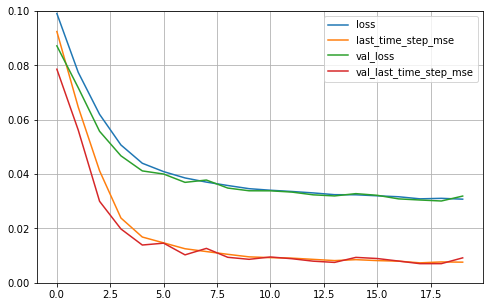

In [14]:
pd.DataFrame(train.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylim(0,0.1)
plt.show()

In [15]:
model.evaluate(x_test,y_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.0321 - last_time_step_mse: 0.0090


[0.03213327005505562, 0.008990923874080181]

In [16]:
y_pred = model.predict(x_test)

32/32 [==============================] - 1s 7ms/step


In [17]:
y_test.shape, y_pred.shape

((1000, 30, 10), (1000, 30, 10))

In [ ]:
i =